# 1. Import modules

In [1]:
# import base libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# training GAN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torch import autograd

# wavlet decomposition, denoise signal
import pywt
from pywt import wavedec

# Import functions
%run ./model.ipynb
%run ./utils.ipynb

# 2. Helper functions

In [2]:
def segmentation_MIT(paths, fs=360, before=88, after=168):
    patient_no = ['100','103','105','106','108','109','111','112','113','114',
                '115','116','117','118','119','121','122','123','124','200','201','202','203','205',
                '207','208','209','210','212','213','214','215','219','220','221','222','223','228',
                '230','231','232','233','234','102','104', '107','217'] # excluded:'102','104','107','217'
    labels = []; leadML2_beats = []; 
    
    for k in range(0,len(patient_no)):
        ann = wfdb.rdann(paths[k][:-4], 'atr') 
        
        if 'MLII' in wfdb.rdsamp(paths[k][:-4])[1].get('sig_name'):
            leadML2 = wfdb.rdsamp(paths[k][:-4])[0][:, 0]
            #lead2 = wfdb.rdsamp(paths[k][:-4])[0][:, 1]
            peaks = ann.sample
            for j in range(len(peaks)-1):
                if peaks[j]>=before and peaks[j]< len(leadML2)-after:
                    if peaks[j] - peaks[j-1] <= before or peaks[j+1] - peaks[j] <= after:
                        continue
                    leadML2_beat = leadML2[peaks[j]-before:peaks[j]+after]
                    leadML2_beats.append(leadML2_beat)
                    labels.append(ann.symbol[j])
    return  leadML2_beats, labels   


'''We exclude specific annotations/beats; for more details about annotations go to: 
https://archive.physionet.org/physiobank/annotations.shtml#aux''' 
def exclude(labels,leadML2):
    '''We exclude specific annotations/beats(the ones from 'exclude_char'); 
    for more details about annotations go to: https://archive.physionet.org/physiobank/annotations.shtml#aux 
    Cathegories recommended by the AAMI standards:
        Normal = ['N','L','R','e','j']
        SVEB = ['A','a','J','S']
        VEB = ['V','E']
        F = ['F']
        Q = ['/', 'Q', 'f']
    '''
    exclude_char = ['~','|','!','[',']','"','no','+','x']
    zero_list=[]
    for i in exclude_char:
        for j in range(len(labels)):
            if labels[j]==i:
                labels[j] = 0  # Finds char from 'exclude_char' and replaces them with zero
                zero_list.append(j)  #find the indexes where labels=0 
    leadML2 = [leadML2[i] for i in range(0, len(labels)) if i not in zero_list] 
    labels = [labels[i] for i in range(0, len(labels)) if i not in zero_list] 
    
    selected_beats = []
    for j in range(len(labels)):
        if labels[j]=="N":
            labels[j] = 'N'
            selected_beats.append(j)
        elif labels[j]=="A":
            labels[j] = 'A'
            selected_beats.append(j)
        elif labels[j]=="V":
            labels[j] = 'V'
            selected_beats.append(j)
        elif labels[j]=='L':
            labels[j] = 'L'
            selected_beats.append(j)
        elif labels[j]=="R":
            labels[j] = 'R'
            selected_beats.append(j)
            
    leadML2 = [leadML2[i] for i in selected_beats]
    #leadV1 = [leadV1[i] for i in selected_beats] 
    labels_beats = [labels[i] for i in selected_beats] 
     
    return labels_beats, leadML2


# 3. Read and pre-process the data

In [3]:
'''Download the database from: https://physionet.org/content/mitdb/1.0.0/'''
import glob
import wfdb
paths = glob.glob('Z:/1938759/Datasets/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/*.atr')             
#paths.pop(1)

[leadML2, labels_beats] = segmentation_MIT(paths, fs=360)

# Choose just 5 classes: N, A, L, R, V
[labels_beats, leadML2] = exclude(labels_beats,leadML2)

# Filter the baseline
leadML2 = denoise_signal(leadML2, dwt_transform= 'db1', cutoff_low=2, cutoff_high=9)

# smooth the signals
leadML2 = Savitzky_Golay(leadML2, fs=360)
# Normalise signals between [-1 and 1]
leadML2 = normalise(leadML2, -1, 1)

classes, counts = np.unique(labels_beats, return_counts=True)
print(np.unique(labels_beats, return_counts=True))

# Encode the labels
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
labels_enc = enc.fit_transform(labels_beats).tolist()

(array(['A', 'L', 'N', 'R', 'V'], dtype='<U1'), array([ 2162,  7900, 68212,  7217,  6372], dtype=int64))


# 4. Prepare data for GAN

In [4]:
signals = torch.from_numpy(np.array(leadML2, dtype=np.float32))
signals = signals.unsqueeze(1)
labels_enc = torch.from_numpy(np.array(labels_enc, dtype=int))

train_data =[([signals[i], labels_enc[i]]) for i in range(len(labels_enc))]

# 5. Design GAN model

### Discriminator

In [5]:
class CNN_Discriminator(nn.Module):
    # Code copied from https://github.com/vlbthambawita/deepfake-ecg/blob/9fa9a02a9fefe579e322d56fa591c3887d7ad135/deepfakeecg/models/pulse2pulse.py#L5
   
    def __init__(self, num_classes, signal_length, model_size=64, ngpus=1, num_channels=2, shift_factor=2,
                 alpha=0.2, verbose=False):
        super(CNN_Discriminator, self).__init__()
        self.num_classes = num_classes
        self.signal_length = signal_length
        self.model_size = model_size  # d
        self.ngpus = ngpus
        self.num_channels = num_channels  # c
        self.shift_factor = shift_factor  # n
        self.alpha = alpha
        self.verbose = verbose
        
        self.embed = nn.Embedding(num_classes, 1*signal_length)
        self.conv1 = nn.Conv1d(num_channels+1,  model_size, 5, stride=2, padding=1)
        self.conv2 = nn.Conv1d(model_size, 2 * model_size, 5, stride=2, padding=1)
        self.conv3 = nn.Conv1d(2 * model_size, 5 * model_size, 5, stride=2, padding=1)
        self.conv4 = nn.Conv1d(5 * model_size, 10 * model_size, 5, stride=2, padding=1)
        self.conv5 = nn.Conv1d(10 * model_size, 20 * model_size, 5, stride=2, padding=1)
        self.conv6 = nn.Conv1d(20 * model_size, 25 * model_size, 5, stride=4, padding=1)
        self.conv7 = nn.Conv1d(25 * model_size, 100 * model_size, 5, stride=4, padding=1)

        self.fc1 = nn.Linear(3200, 1)
#         for m in self.modules():
#             if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
#                  nn.init.normal_(m.weight.data, 0.0, 0.02)
                 
#                     #nn.init.kaiming_normal_(m.weight.data)   #kaiming_normal_

    def forward(self, x, labels):
        #print(x.shape)
        embedding = self.embed(labels).view(labels.shape[0], 1,self.signal_length) 
        #print(embedding.shape)
       

        x = torch.cat([x,embedding], dim=1) # N x C x channel_signal x signal_length
        
        
        x = F.leaky_relu(self.conv1(x), negative_slope=self.alpha)
        if self.verbose:
            print(x.shape)
        
        x = F.leaky_relu(self.conv2(x), negative_slope=self.alpha)
        if self.verbose:
            print(x.shape)
        
        x = F.leaky_relu(self.conv3(x), negative_slope=self.alpha)
        if self.verbose:
            print(x.shape)  

        x = F.leaky_relu(self.conv4(x), negative_slope=self.alpha)
        if self.verbose:
            print(x.shape)
        
        
        x = F.leaky_relu(self.conv5(x), negative_slope=self.alpha)
        if self.verbose:
            print(x.shape)
        #x = self.ps5(x)
        

        x = F.leaky_relu(self.conv6(x), negative_slope=self.alpha)
        if self.verbose:
            print(x.shape)

        x = x.view(-1, x.shape[1] * x.shape[2])
  
        if self.verbose:
            print(x.shape)
       
        return self.fc1(x)

### Generator

In [6]:

'''Adapted from https://github.com/milesial/Pytorch-UNet by James Howard (2D -> 1D)'''

class DoubleConv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv1d(in_ch, out_ch, 3, padding=1)
        self.bn = nn.BatchNorm1d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_ch, out_ch, 3, padding=1)
    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        #x = self.bn(x)
        x = self.relu(x)
        return x

class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x):
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=None):
        super(Down, self).__init__()
        self.dropout = dropout
        self.maxpool = nn.MaxPool1d(2)
        self.dbc = DoubleConv(in_ch, out_ch)
    def forward(self, x):
        x = self.maxpool(x)
        x = self.dbc(x)
        if self.dropout:
            x = F.dropout(x, self.dropout)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose1d(in_ch // 2, in_ch // 2, 2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diff = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, (diff // 2, diff - diff // 2))
        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1) # dim=1 because we add them on channel dimension 
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)
    def forward(self, x):
        x = self.conv(x)
        return x


class UNet1D(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes, embed_size, n_layers, ngpus=1, starting_layers=128, dropout=None):
        super(UNet1D, self).__init__()
        self.dropout = dropout
        self.n_layers = n_layers
        self.inc = InConv(in_channels+1, starting_layers)
        self.down1 = Down(starting_layers * 1, starting_layers * 2, dropout)  # Only dropout on early layers
        self.down2 = Down(starting_layers * 2, starting_layers * 4, dropout)
        self.down3 = Down(starting_layers * 4, starting_layers * 8, dropout)
        self.down4 = Down(starting_layers * 8, starting_layers * 8, dropout)
        if self.n_layers >= 5:
            self.down5 = Down(starting_layers * 8, starting_layers * 8)
            if self.n_layers >= 6:
                self.down6 = Down(starting_layers * 8, starting_layers * 8)
                self.up6 = Up(starting_layers * 16, starting_layers * 8)
            self.up5 = Up(starting_layers * 16, starting_layers * 8)
        self.up4 = Up(starting_layers * 16, starting_layers * 4)
        self.up3 = Up(starting_layers * 8, starting_layers * 2)
        self.up2 = Up(starting_layers * 4, starting_layers)
        self.up1 = Up(starting_layers * 2, starting_layers)
        self.out = OutConv(starting_layers, out_channels)
        self.embed = nn.Embedding(num_classes, embed_size)
        
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
    def forward(self, x,labels):
        embedding = self.embed(labels).unsqueeze(1)#.unsqueeze(3) # adds 1 x 1 at the end
        #print(embedding.shape)
        #print(x.shape)
        x = torch.cat([x, embedding],dim=1)
        #print(x.shape)
        
        
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        if self.n_layers >= 4:
            x5 = self.down4(x4)
            x = x5
            if self.n_layers >= 5:
                x6 = self.down5(x5)
                x = x6
                if self.n_layers >= 6:
                    x7 = self.down6(x6)
                    x = x7
                    x = self.up6(x, x6)
                x = self.up5(x, x5)
            x = self.up4(x, x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)
        x = torch.tanh(self.out(x))
        
        # latent vector z: N x noise_dim x 1 x 1
        
        return x


In [7]:
def gradient_penalty(critic, labels, real, fake, device):
    BATCH_SIZE, H, W = real.shape

    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, H, W).to(device)
    
    # Interpolate between real and fake data
    interpolates = real * alpha + fake * (1 - alpha)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    # Calculate critic scores
    mixed_scores = critic(interpolates,labels)

    # Take the gradient of the scores with respect to the input signals
    gradient = torch.autograd.grad(
        inputs=interpolates,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty    

def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
            #nn.init.normal_(m.weight.data, 0.0, 0.02)
            nn.init.kaiming_normal_(m.weight.data)

# 6. Set up the WGAN hyperparameters

In [ ]:
import wandb
os.environ["WANDB_API_KEY"] = 'b8b8e375fa11f69790bff448e326c90a5435494b'
os.environ["WANDB_MODE"] = "offline"

In [8]:
# Set the random seed for NumPy
np.random.seed(42)

# Set the random seed for PyTorch (CPU)
torch.manual_seed(42)

# If using GPU, set the random seed for CUDA as well
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
unique, counts = np.unique(labels_enc, return_counts=True)
print(unique, counts)

In [ ]:
# array(['A', 'L', 'N', 'R', 'V'], dtype='<U1'), array([ 1107,  8070, 58063,  4074,  6193], dtype=int64))

In [ ]:
# Hyperparameters 
channels_signal = 1
latent_dim = np.shape(np.array(signals))[2]
generator_layers = 6

batch_size = 16
discriminator_updates = 5
num_epochs = 100

num_classes = len(unique)
embed_size = np.shape(np.array(signals))[2]
signal_length = np.shape(np.array(signals))[2]

LAMBDA_GP = 10
no_of_batches = len(signals)/batch_size 
batches_per_epoch = round(len(signals)/batch_size)

gen_name = f"Gen_MIT_all_{num_epochs}_3C"
disc_name = f"Disc_MIT_all_{num_epochs}_3C"

In [ ]:
len(unique)

In [ ]:
# capture a dictionary of hyperparameters with config
device =  "cuda:1" #if torch.cuda.is_available() 
config = {"learning_rate_critic": 0.00001, 
          "learning_rate_generator": 0.00001, #0.00005 ,
          "epochs": num_epochs,
          "Channels": channels_signal,
          "architecture": "connections_instancenorm",
          "dropout":"none",
          "machine": "GPU_server",
          "batch_size": batch_size, 
          "generator_layers": generator_layers, 
          "discriminator_updates":discriminator_updates,
          "LAMBDA_GP":LAMBDA_GP, 
          "Optimizer":'Adam+betas0.5and0.9', 
          "Generator":'UNet1D', 
          "Discriminator":'CNN', 
          "data": "leadML2",
          "type_GAN":'CGAN', 
          "classes":unique,
          "gen_name": gen_name,
          "disc_name": disc_name
         }

In [ ]:
with wandb.init(project='WGAN_MIT', entity='ioanacretu', config=config):
    config = wandb.config

    # Create dataset and dataloader
    #dataloader = DataLoader(ECG_BP,batch_size=config.batch_size, shuffle=True, num_workers=2)
    trainloader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True, drop_last=True)

    # Create discriminator and generator
    critic = CNN_Discriminator(num_classes, signal_length, num_channels=channels_signal).to(device) 
    generator = UNet1D(channels_signal, channels_signal, num_classes, embed_size, n_layers=config.generator_layers).to(device)

    initialize_weights(critic)
    initialize_weights(generator)

    # Set up Optimizer for G and D
    optimizer_critic =  optim.Adam(critic.parameters(), lr=config.learning_rate_critic, betas=(0.5, 0.9))
    optimizer_generator = optim.Adam(generator.parameters(), lr=config.learning_rate_generator, betas=(0.5, 0.9))

#         optimizer_critic =  optim.Adam(critic.parameters(), lr=config.learning_rate, betas=(0, 0.9))
#         optimizer_generator = optim.Adam(generator.parameters(),lr=config.learning_rate, betas=(0, 0.9))

    # Watch weights and gradients for both critic and generator
    wandb.watch(critic, log="all")
    wandb.watch(generator, log="all")

    #fixed_noise = torch.randn(batch_size,latent_dim,1).to(device)
    fixed_noise = torch.randn(config.batch_size,channels_signal,latent_dim).uniform_(-1, 1).to(device)
    fixed_labels = torch.randint(low=0, high=num_classes, size=(config.batch_size,)).to(device)

#         if wandb.run.resumed:
#             checkpoint_filename_disc = f"\disc_APVP_AVD200_epoch{epoch + 1}.pth"
#             checkpoint_filename_gen = f"\gen_APVP_AVD200_epoch{epoch + 1}.pth"
#             checkpoint_path_disc = 
#             checkpoint_path_gen = 

#             checkpoint = torch.load(wandb.restore(CHECKPOINT_PATH))
#             model.load_state_dict(checkpoint['model_state_dict'])
#             optimizer_generator.load_state_dict(checkpoint['optimizer_state_dict'])
#             epoch = checkpoint['epoch']
#             loss = checkpoint['loss']


    critic_iter = 0
    gen_iter = 0


    print("Starting training...")
    for epoch in range(config.epochs):

        # set both networks for training mode
        generator.train()
        critic.train()

        # initiate the epoch loss for both networks to zero
        batch_nr = 0
        epoch_loss_critic = 0.
        epoch_loss_generator = 0.
        all_loss_critic = 0.

        print(f'Epoch: {epoch}')
        for batch_idx, (data,labels) in enumerate(trainloader):
            step_loss_critic = 0.
            batch_nr += 1

            data = data.to(device)
            labels = labels.to(device)
            data = data.float()  #solved error "Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same"
            count=0
            # Train the Critic/Discriminator: max E[critic(real)] - E[critic(fake)]
            for _ in range(config.discriminator_updates):
                critic_iter = critic_iter +1
                count = count+1
                noise = torch.randn(config.batch_size,channels_signal,latent_dim).uniform_(-1, 1).to(device)
                fake = generator(noise,labels)

                critic_real = critic(data,labels).reshape(-1)
                critic_fake = critic(fake.detach(),labels).reshape(-1)   #critic(fake,labels).reshape(-1) #here we changed according to github repo alladin, it was before critic_fake = critic(fake.detach(),labels).reshape(-1)

                gp = gradient_penalty(critic,labels, data, fake, device = device)
                loss_critic =(-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp)
                wandb.log({"Epoch":epoch, "Critic_loss": loss_critic, "Critic_iteration": critic_iter})

                step_loss_critic += loss_critic.item()
                critic.zero_grad()
                loss_critic.backward(retain_graph=True)
                optimizer_critic.step()
            #all_loss_critic += step_loss_critic/discriminator_updates    
           ## clear memory after a no of steps: is it enought to keep the w. for disc_updates steps? ##loss_critic.backward(retain_graph=False)
            # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
            gen_iter = gen_iter + 1
            gen_fake = critic(fake,labels).reshape(-1)
            loss_generator = -torch.mean(gen_fake)
            #epoch_loss_generator += loss_generator.item()

            generator.zero_grad()
            loss_generator.backward()
            optimizer_generator.step()
            wandb.log({"Epoch":epoch, "Generator_iteration": gen_iter, "Generator_loss": loss_generator})   

        print(f"Gen loss:{loss_generator}")
        print(f"Critic loss::{np.mean(step_loss_critic)}")   

#             # Save model checkpoints
#             if (epoch + 1) % 500 == 0:
#                 checkpoint_filename_disc = f"\disc_APVP_AVD200_epoch{epoch + 1}.pth"
#                 checkpoint_filename_gen = f"\gen_APVP_AVD200_epoch{epoch + 1}.pth"

#                 checkpoint_path_disc = wandb.run.dir + checkpoint_filename_disc
#                 checkpoint_path_gen = wandb.run.dir + checkpoint_filename_gen

#                 torch.save({'epoch': epoch,'model_state_dict': critic.state_dict(),
#                             'optimizer_state_dict': optimizer_critic.state_dict(),
#                             'loss': config.learning_rate_critic,}, checkpoint_path_disc)
#                 wandb.save(checkpoint_path_disc)

#                 torch.save({'epoch': epoch,'model_state_dict': generator.state_dict(),
#                             'optimizer_state_dict': optimizer_generator.state_dict(),
#                             'loss': config.learning_rate_generator,}, checkpoint_path_gen)
#                 wandb.save(checkpoint_path_gen)

        # Diplay the signals produced by the generator every 100 epochs
        if (epoch + 1) % 100 == 0:
            generator.eval()
            with torch.no_grad():
                generated_signals = generator(fixed_noise, fixed_labels)
                gener = generated_signals.cpu().detach().numpy()
                plt.figure(figsize=(8,3))
                plt.title(f'Label: APVP_120')
                plt.plot(gener[0][0])
            

                # Log the figure to WandB
                wandb.log({'chart': plt})
print('Finished Training')

In [ ]:
labels_enc

In [ ]:
n=10

# array(['A', 'L', 'N', 'R', 'V'], dtype='<U1'), array([ 1107,  8070, 58063,  4074,  6193], dtype=int64))
#          0,  1,   2,   3,   4,

plt.figure(figsize=(10,5))
plt.subplot(211)
plt.title(f'Generated Label: {labels[n]}')
plt.plot(gener[n][0])
plt.margins(0)

plt.subplot(212)
plt.title(f'Original Label: {labels[n]}')
plt.plot(signals[58905][0])
plt.margins(0)


In [ ]:
PATH = r'Z:\1938759\Synhtetic signal simulator\Our-data\models_mit'
torch.save(generator.state_dict(), os.path.join(PATH,f'Gen_MIT_300e.pth'))
torch.save(critic.state_dict(), os.path.join(PATH,f'.Des_MIT_300e.pth'))

# Load the generator and test it

In [9]:
device =  "cuda" if torch.cuda.is_available() else "cpu"  
import random

channels_signal = 1
num_classes=5
embed_size = 256  
latent_dim = 256
generator_layers = 6

generator_PATH = r'Z:\1938759\Synhtetic signal simulator\Our-data\models_mit\Gen_MIT_300e.pth'
generator_loaded = UNet1D(channels_signal, channels_signal, num_classes,embed_size, n_layers = generator_layers).to(device)
generator_loaded.load_state_dict(torch.load(generator_PATH))
generator_loaded.eval()

#generator = generator.to(device)
labels = np.zeros(10)
for i in range(len(labels)):
    labels[i] = 2 # random.randrange(0,6,1)
    
batch_size = len(labels)
latent_dim = 256
fixed_noise = torch.randn(batch_size,channels_signal,latent_dim).uniform_(-1, 1).to(device)
labels =  torch.Tensor(labels).to(device)
labels = labels.int()

generated_signals = generator_loaded(fixed_noise,labels)
gener = generated_signals.cpu().detach().numpy()

In [ ]:
for i in range(len(labels_enc)):
    if labels_enc[i]==2:
        print(i)

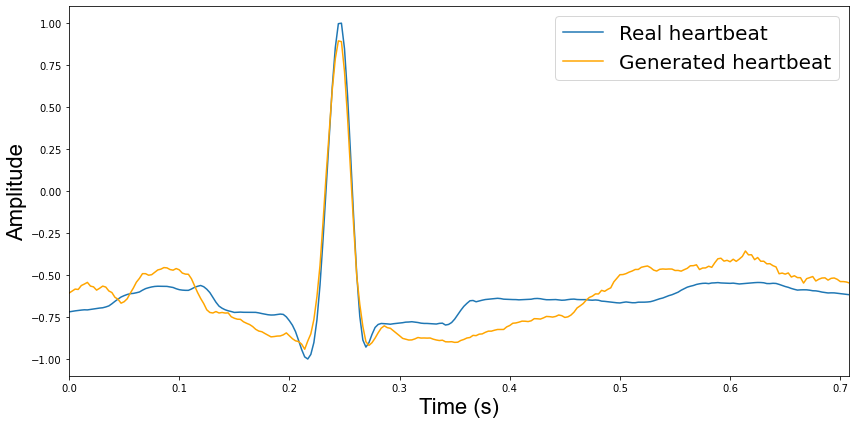

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling frequency
fs = 360  # 360 Hz

# Create a time vector
N = len(leadML2[0])
time = np.linspace(0, (N-1)/fs, N)

# Plotting
plt.figure(figsize=(12, 6))  # Increase the figure size for better clarity

#plt.subplot(211)
plt.plot(time, leadML2[55], label='Real heartbeat')
#plt.title('Real Heartbeat', fontname='Arial', fontsize=18)
#plt.xlabel('Time (s)', fontname='Arial', fontsize=16)
#plt.ylabel('Signal Amplitude', fontname='Arial', fontsize=16)
#plt.margins(x=0)
#plt.grid(True)  # Optionally turn on the grid for better readability

generated = gener[3].reshape(-1)
#plt.subplot(212)
plt.plot(time, generated, color='orange', label='Generated heartbeat')
#plt.title('Synthetic Heartbeat', fontname='Arial', fontsize=18)
plt.xlabel('Time (s)', fontname='Arial', fontsize=22)
plt.ylabel('Amplitude', fontname='Arial', fontsize=22)
#plt.grid(True)  # Optionally turn on the grid for better readability

plt.margins(x=0)
plt.legend(fontsize=20)
plt.tight_layout()  # This automatically adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()


# Optimised evaluator

In [ ]:
import random
import numpy as np
import torch
from frechetdist import frdist
import math
import time
#import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from dtaidistance import dtw, dtw_ndim

# Record the start time
start_time = time.time()

class GANEvaluator:
    def __init__(self, real_signals, fake_signals, device):
        self.device = device
        self.real_signals = [torch.tensor(signal, device=self.device).float() for signal in real_signals]
        self.fake_signals = [torch.tensor(signal, device=self.device).float() for signal in fake_signals]
        self.time = torch.arange(0, len(self.real_signals[0]), device=self.device) / 360

    def shuffle_data(self, data):
        random.shuffle(data)

    def frechet_distance(self):
        frechet_distances = []
        for real_points in self.real_signals:
            P = torch.stack([self.time, real_points], dim=1).cpu().numpy()
            fd = []
            for fake_points in self.fake_signals:
                Q = torch.stack([self.time, fake_points], dim=1).cpu().numpy()
                fd.append(frdist(P, Q))
            frechet_distances.append(min(fd))
        return np.mean(frechet_distances)

    def calculate_metric(self, metric_func):
        metrics = []
        for real_points in self.real_signals:
            tmp_metrics = []
            for fake_points in self.fake_signals:
                if len(real_points) != len(fake_points):
                    raise ValueError("Both lists of signals must have the same length.")
                tmp_metrics.append(metric_func(real_points, fake_points).item())
            metrics.append(min(tmp_metrics))
        return np.mean(metrics)

    def MSE(self, real, fake):
        return (real - fake).pow(2).mean()

    def RMSE(self, real, fake):
        return torch.sqrt((real - fake).pow(2).mean())

    def MAE(self, real, fake):
        return torch.abs(real - fake).mean()

    def calculate_prmse(self):
        prmse_values = []
        for real_points in self.real_signals:
            max_real_value = torch.max(real_points)
            tmp_squared_errors = []
            for fake_points in self.fake_signals:
                rmse = torch.sqrt(((real_points - fake_points) ** 2).mean()).item()
                tmp_squared_errors.append(rmse ** 2)
            min_squared_error = min(tmp_squared_errors)
            prmse_percentage = (np.sqrt(min_squared_error) / max_real_value.item()) * 100
            prmse_values.append(prmse_percentage)
        return np.mean(prmse_values)
    
    def gaussian_kernel(self, X, Y, sigma=1.0):
        XX = torch.matmul(X, X.T)
        XY = torch.matmul(X, Y.T)
        YY = torch.matmul(Y, Y.T)
        X_sqnorms = torch.diagonal(XX)
        Y_sqnorms = torch.diagonal(YY)
        
        K = torch.exp(-0.5 * (X_sqnorms[:, None] + Y_sqnorms[None, :] - 2 * XY) / sigma**2)
        return K

    def mmd(self, sigma=1.0):
        mmd_distances = []
        for real_points in self.real_signals:
            P = real_points.unsqueeze(1)
            mmd_values = []
            for fake_points in self.fake_signals:
                Q = fake_points.unsqueeze(1)
                
                K_PP = self.gaussian_kernel(P, P, sigma)
                K_QQ = self.gaussian_kernel(Q, Q, sigma)
                K_PQ = self.gaussian_kernel(P, Q, sigma)
                
                mmd_value = K_PP.mean() + K_QQ.mean() - 2 * K_PQ.mean()
                mmd_values.append(mmd_value.item())
            mmd_distances.append(min(mmd_values))
        return np.mean(mmd_distances)
    
    def dtw_distance(self):
        dtw_distances = []
        for real_signal in self.real_signals:
            real_signal = real_signal.cpu().numpy()
            dtw_per_real = []
            for fake_signal in self.fake_signals:
                fake_signal = fake_signal.cpu().numpy()
                #print(f"Real signal shape: {real_signal.shape}, Fake signal shape: {fake_signal.shape}")
                if real_signal.ndim == 1 and fake_signal.ndim == 1:
                    # Univariate case
                    distance = dtw.distance(real_signal, fake_signal)
                    dtw_per_real.append(distance)
                elif real_signal.ndim == 2 and fake_signal.ndim == 2:
                    # Multivariate case
                    distance = dtw_ndim.distance(real_signal, fake_signal)
                    dtw_per_real.append(distance)
                else:
                    raise ValueError("Mismatched dimensions between real and fake signals")
            dtw_distances.append(min(dtw_per_real))
        return np.mean(dtw_distances)
    
    
# # Rest of the setup and method calls remain the same


# # Check if GPU is available and set device accordingly
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# # Prepare the data 
# original_ecg_data = np.squeeze(np.array(L_beats), axis=1)
# generated_ecg_data = np.squeeze(np.array(gener), axis=1)

# # Instantiate the GANEvaluator class
# gan_evaluator = GANEvaluator(original_ecg_data, generated_ecg_data, device)

# # Call each function on the instance
# gan_evaluator.shuffle_data(original_ecg_data)
# frechet_dist_value = gan_evaluator.frechet_distance()
# mse_value = gan_evaluator.calculate_metric(gan_evaluator.MSE)
# rmse_value = gan_evaluator.calculate_metric(gan_evaluator.RMSE)
# mae_value = gan_evaluator.calculate_metric(gan_evaluator.MAE)
# prmse_value = gan_evaluator.calculate_prmse()

# # Print the results
# print(f'Frechet Distance value: {frechet_dist_value}')
# print(f'MSE value for ECG signals is: {mse_value}')
# print(f'RMSE value for ECG signal is: {rmse_value}')
# print(f'MAE value for ECG signals is: {mae_value}')
# print(f'PRMSE value for ECG signals is: {prmse_value}')

# # Record the end time
# end_time = time.time()

# # Calculate and print the elapsed time
# elapsed_time = end_time - start_time
# print(f"The code took {elapsed_time} seconds to run.")
# print(f"The code took {elapsed_time/3600} hours to run.")

In [ ]:
import torch
import numpy as np
from scipy.spatial.distance import cdist

def evaluate_all(path, generated_samples):
    
    signal_labels_numeric = [0, 1, 2, 3, 4]
    signal_labels_real = ['A','L', 'N', 'R', 'V']
    
    device =  "cuda" if torch.cuda.is_available() else "cpu"  
    
    channels_signal = 1
    num_classes=5
    embed_size = 256  
    latent_dim = 256
    generator_layers = 6
    latent_dim = 256

    generator_PATH = r'Z:\1938759\Synhtetic signal simulator\Our-data\models_mit\Gen_MIT_300e.pth'
    generator_loaded = UNet1D(channels_signal, channels_signal, num_classes,embed_size, n_layers = generator_layers).to(device)
    generator_loaded.load_state_dict(torch.load(generator_PATH))
    generator_loaded.eval()
    
    for i in range(len(signal_labels_numeric)):
        labels = np.zeros(generated_samples)
        batch_size = len(labels)
        
        for j in range(len(labels)):
            labels[j] = signal_labels_numeric[i] 

        fixed_noise = torch.randn(batch_size,channels_signal,latent_dim).uniform_(-1, 1).to(device)
        labels =  torch.Tensor(labels).to(device)
        labels = labels.int()

        generated_signals = generator_loaded(fixed_noise,labels)
        gener = generated_signals.cpu().detach().numpy()
        
        # Identify the heartbeats/signals that have the label the same as the selected label from the list
        real_beats = []
        for k in range(0,len(labels_beats)):
            if labels_beats[k] == signal_labels_real[i]:
                real_beats.append(i)

        real_beats = [np.array(leadML2[i]) for i in real_beats]
        real_beats =  np.array(real_beats).reshape((len(real_beats), 1, 256))
        
        
        print(f'The class evaluated is: {signal_labels_real[i]}')
        # Prepare the data 
        random_selected = random.sample(list(real_beats), generated_samples)
        original_ecg_data = np.squeeze(np.array(random_selected), axis=1)
        generated_ecg_data = np.squeeze(np.array(gener), axis=1)
        
        # Instantiate the GANEvaluator class
        gan_evaluator = GANEvaluator(original_ecg_data, generated_ecg_data, device)

        # Call each function on the instance and # Print the results
        gan_evaluator.shuffle_data(original_ecg_data)
        
        start_time = time.time()

        mse_value = gan_evaluator.calculate_metric(gan_evaluator.MSE)
        print(f'MSE value for ECG signals is: {mse_value}')
        rmse_value = gan_evaluator.calculate_metric(gan_evaluator.RMSE)
        print(f'RMSE value for ECG signal is: {rmse_value}')
        mae_value = gan_evaluator.calculate_metric(gan_evaluator.MAE)
        print(f'MAE value for ECG signals is: {mae_value}')
        prmse_value = gan_evaluator.calculate_prmse()
        print(f'PRMSE value for ECG signals is: {prmse_value}')
        dtw_distance = gan_evaluator.calculate_dtw_distance()
        print(f'DTW value for ECG signals is: {dtw_distance}')
        frechet_dist_value = gan_evaluator.frechet_distance()
        print(f'Frechet Distance value: {frechet_dist_value}')

        
        # Record the end time
        end_time = time.time()
        
        #mmd_value = gan_evaluator.mmd(sigma=1.0)
        #print(f'MMD value: {mmd_value}')
        dtw_value = gan_evaluator.dtw_distance()
        print(f'DTW value: {dtw_value}')
        
        # Calculate and print the elapsed time
        elapsed_time = end_time - start_time
        print(f"The code took {elapsed_time} seconds to run.")
        print(f"The code took {elapsed_time/3600} hours to run.")
        
        print('________________________________________________________')

In [ ]:
generator_PATH = r'Z:\1938759\Synhtetic signal simulator\Our-data\models_mit\Gen_MIT_300e.pth'

In [ ]:
evaluate_all(generator_PATH, 100)